In [1]:
using PyCall, BSON, DecisionTree, Random, Statistics

In [2]:
spacy = pyimport("spacy");

In [3]:
nlp = spacy.load("en_core_web_lg")

PyObject <spacy.lang.en.English object at 0x7f571ce7ff50>

In [4]:
BSON.@load "models/model_rf.bson" rf

In [5]:
function prepare_input(doc)
    data = Matrix{Union{Missing, String}}(undef, 0, 7)
    for i in 1:length(doc)
        token = doc[i]
        if i != 1
            previous = doc[i - 1].pos_
        else
            previous = "None"
        end
        row = [token.pos_, token.tag_, token.dep_, token.head.pos_,
               token.head.tag_, token.head.dep_, previous]
        data = vcat(data, reshape(row, (1, 7)))
    end
    return data
end

prepare_input (generic function with 1 method)

In [6]:
function alpha(doc, model)
    input = prepare_input(doc)
    return predict(model, input)
end

alpha (generic function with 1 method)

In [7]:
using SimpleHypergraphs

In [8]:
import LightGraphs

Vertices - words in sentence

In [9]:
test = Hypergraph{Float64}(6, 3); test[4:6, 1] .= 1; test[3:6, 2] .= 1; test[:, 3] .= 1

6-element view(::Hypergraph{Float64, Nothing, Nothing, Dict{Int64, Float64}}, :, 3) with eltype Union{Nothing, Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [10]:
test

6×3 Hypergraph{Float64, Nothing, Nothing, Dict{Int64, Float64}}:
  nothing   nothing  1.0
  nothing   nothing  1.0
  nothing  1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0
 1.0       1.0       1.0

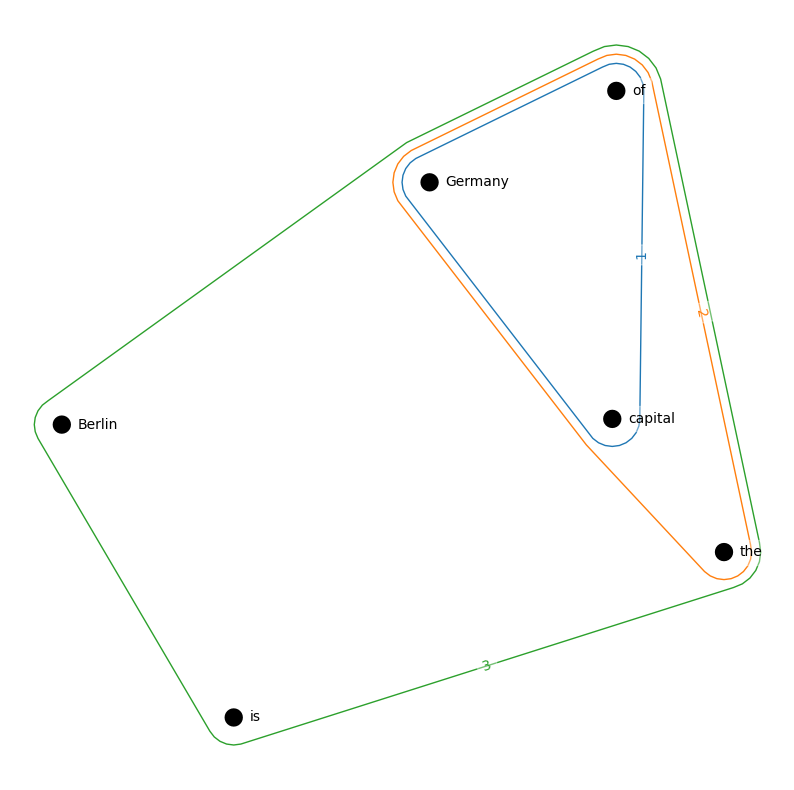

In [11]:
SimpleHypergraphs.draw(
    test, 
    HyperNetX; 
#     width=500, 
#     height=500,
    with_node_labels=true, #whether displaying or not node labels
    node_labels=Dict(1 => "Berlin", 2 => "is", 3 => "the", 4 => "of", 5 => "capital", 6 => "Germany")
)

In [12]:
pattern_1 = ("M", "x")
pattern_2 = ("B", "C", "C", "+")
pattern_3 = ("T", ["C", "R"])
pattern_4 = ("P", ["C", "R", "S"], "+")
pattern_5 = ("J", "x")
# patterns = Dict(pattern_1 => "x",
#                 pattern_2 => "C",
#                 pattern_3 => "S",
#                 pattern_4 => "R")
patterns = [pattern_1, pattern_2, pattern_3, pattern_4, pattern_5]

5-element Vector{Tuple{String, Any, Vararg{String, N} where N}}:
 ("M", "x")
 ("B", "C", "C", "+")
 ("T", ["C", "R"])
 ("P", ["C", "R", "S"], "+")
 ("J", "x")

In [13]:
function find_pattern(pattern, seq)
    if pattern[1] in seq
        if (pattern[1] == "M") & (length(seq) == 2)
            if seq[1] != "M"
                return([seq[2], seq[1]], seq[1], [2, 1])
            else
                return(seq, seq[2], [1, 2])
            end
        elseif (pattern[1] == "B") & (length(seq) > 2)
            rest = filter(e->e≠"B", seq)
            if ((length(rest) + 1) == length(seq)) & (all(y->y == "C", rest))
                order = findall(isequal("B"), seq)
                return(append!(["B"], rest), "C", append!(order, [i for i in 1:length(seq) if i != order[1]]))
            end
        elseif (pattern[1] == "T") & (length(seq) == 2)
            rest = filter(e->e≠"T", seq)
            if (length(rest) == 1) & (rest[1] in ["C", "R"])
                order = findall(isequal("T"), seq)
                return(append!(["T"], rest), "S", append!(order, [i for i in 1:length(seq) if i != order[1]]))
            end
        elseif (pattern[1] == "P")
            rest = filter(e->e≠"P", seq)
            if (all(y->y in ["C", "S", "R"], rest)) & ((length(rest) + 1) == length(seq))
                order = findall(isequal("P"), seq)
                return(append!(["P"], rest), "R", append!(order, [i for i in 1:length(seq) if i != order[1]]))
            end
        elseif (pattern[1] == "J")
            rest = filter(e->e≠"J", seq)
            if (length(rest) == 2)
                order = [findfirst(isequal("J"), seq)]
                return(append!(["J"], rest), rest[1], append!(order, [i for i in 1:length(seq) if i != order[1]]))
            end
        end
    end
end

find_pattern (generic function with 1 method)

In [14]:
function function_h(hg, doc)
    tokens = [token for token in doc]
    texts = [token.text for token in tokens]
    score = 0
    global ones_hg = [[i for i in 1:nhv(hg) if hg[i, e] == 1] for e in 1:nhe(hg)]
    connected_vertices = [i for i in 1:nhv(hg) if 
                         length([e for e in 1:nhe(hg) if hg[i, e] == 1]) > 2]
    if length(connected_vertices) < 1
        score = 1
        for v in 1:length(ones_hg)
            tokens_new = tokens[ones_hg[v]]
            depths = [length([ancestor.text for ancestor in token.ancestors]) 
                                               for token in tokens_new]
            min_depths = findall(isequal(minimum(depths)), depths)
            min_depth_token = tokens_new[findfirst(isequal(minimum(depths)), depths)]
            rest = [token for token in tokens_new if token != min_depth_token]
            if length(min_depths) > 1
                return 0
            end
            childs = []
            for token in tokens_new
                children_token = [child for child in token.children]
                append!(childs, children_token)
            end
            if any(y->y ∉ childs, rest)
                return 0
            end
        end
        return score
    end
    for e in 1:length(ones_hg)
        check = []
        for rest_e in 1:length(ones_hg)
            if rest_e == e
                break
            end
            head_indexes = [findfirst(isequal(token.head.text), texts) for token in tokens[ones_hg[rest_e]]]
            child_indexes = [findfirst(isequal(child), tokens) 
                            for token in tokens[ones_hg[rest_e]] for child in token.children]
            if any(y->y in ones_hg[e], vcat(head_indexes, child_indexes))
                append!([true], check)
            else
                append!([false], check)
            end
        end
        if all(check)
            score += 1
        end
    end
    return score
end     

function_h (generic function with 1 method)

In [15]:
function find_original(hg, indexes)
    if all(y->y == nothing, hg)
        return indexes
    end
    mapping = Dict()
    i = 1
    connected_vertices = []
    for v in 1:nhv(hg)
        if v in connected_vertices
            mapping[i] = (minimum(connected_vertices), maximum(connected_vertices))
            continue
        end
        if all(y->y == nothing, hg[v, :])
            mapping[i] = (v, v)
        else
            edge = maximum([e for e in 1:length(hg[v, :]) if hg[v, e] == 1])
            connected_vertices = [v]
            for vertice in (v+1):length(hg[:, edge])
                if hg[vertice, edge] == nothing
                    break
                end
                append!(connected_vertices, vertice)
            end
            mapping[i] = (minimum(connected_vertices), maximum(connected_vertices))
        end
        i += 1
    end
    first = mapping[indexes[1]][1]
    last = mapping[indexes[2]][2]
    return (first, last)
end

find_original (generic function with 1 method)

In [16]:
function get_copy_hg(hg)
    return Hypergraph(copy(hg))
end

get_copy_hg (generic function with 1 method)

In [17]:
function get_depth(hg, depths, indexes)
    valid_indexes = []
    for i in indexes[1]:indexes[2]
        if all(y->y == nothing, hg[i, :])
            append!(valid_indexes, i)
        end
    end
    if length(valid_indexes) < 1
        return(mean(depths[indexes[1]:indexes[2]]))
    else
        return mean(depths[valid_indexes])
    end
end
        

get_depth (generic function with 1 method)

In [18]:
function parsing(hg, parsed_text, order)
    output = Dict()
    ones_hg = [[i for i in 1:nhv(hg) if hg[i, e] == 1] for e in 1:nhe(hg)]
    for e in 1:nhe(hg)
        output[e] = Any[]
        if e != 1
            connected_edges = [edge for edge in 1:e-1 
                               if all(y->y in ones_hg[e], ones_hg[edge])]
            if length(connected_edges) == 0
                indexes = [i + ones_hg[e][1] - 1 for i in order[e]]
                output[e] = parsed_text[indexes]
            elseif length(connected_edges) == 1
                closest_edge = output[connected_edges[1]]
                rest = [index for index in ones_hg[e] 
                        if index ∉ ones_hg[connected_edges[1]]]
                for o in order[e][1:length(rest)]
                    push!(output[e], parsed_text[rest][o])
                end
                push!(output[e], closest_edge)
            else
                vertices_edges = []
                for edge in connected_edges
                    append!(vertices_edges, ones_hg[edge])
                end
                edges_check = [edge for edge in 1:e-1 
                               if all(y->y in ones_hg[edge], vertices_edges)]
                if length(edges_check) > 0
                    closest_edge = output[maximum(edges_check)]
                    rest = [index for index in ones_hg[e] 
                            if index ∉ ones_hg[maximum(edges_check)]]
                    for o in order[e][1:length(rest)]
                        push!(output[e], parsed_text[rest][o])
                    end
                    push!(output[e], closest_edge)
                else
                    rest = [index for index in ones_hg[e]
                            if index ∉ vertices_edges]
                    for atom in rest
                        push!(output[e], parsed_text[atom])
                    end
                    for edge in connected_edges
                        push!(output[e], output[edge])
                    end
                end
            end
        else
            indexes = [(i + ones_hg[e][1] - 1) for i in order[e]]
            output[e] = parsed_text[indexes]
        end
    end
    return output
end 

parsing (generic function with 1 method)

In [19]:
function adjust_order(order, output, indexes, orig_indexes)
    new_order = []
    orig_indexes = [i for i in orig_indexes[1]:orig_indexes[2]]
    for i in order
        if i ∉ orig_indexes
            append!(new_order, i)
        else
            index_i = findfirst(isequal(i), orig_indexes)
            append!(new_order, output[3][index_i] + length(orig_indexes))

LoadError: syntax: incomplete: "if" at In[19]:5 requires end

In [20]:
function beta(patterns, doc, atoms)
    global tokens = [token for token in doc]
    global depths = [length([ancestor.text for ancestor in token.ancestors]) 
                                           for token in tokens]
    global atoms_depths = [[atom for atom in atoms], [depth for depth in depths]]
    global parsed_text = [(atom, token.text) for (token, atom) in zip(doc, atoms)]
    global hypergraph = Hypergraph{Float64}(length([token for token in doc]), 1)
    global order = []
    while any(y->y != 1, hypergraph[:, nhe(hypergraph)])
        global depth_best = 0
        global h_best = 0
        global count_best = 0
        found_patterns = []
        for pattern in patterns
            for i in 1:length(atoms_depths[1])
                start = i+1
                for j in start:length(atoms_depths[1])
                    output = find_pattern(pattern, atoms_depths[1][i:j])
                    if output != nothing
                        count = length(output[1])
                        append!(found_patterns, output)
                        orig_indexes = find_original(hypergraph, (i, j))
                        depth = get_depth(hypergraph, depths, orig_indexes)
                        copy_hg = get_copy_hg(hypergraph)
                        copy_hg[orig_indexes[1]:orig_indexes[2], nhe(copy_hg)] .= 1
                        h = function_h(copy_hg, doc)
                        if (h > h_best) | ((h == h_best) & ((depth > depth_best))) |
                           ((h == h_best) & (depth == depth_best) & (count > count_best))
                            global best_output = output
                            global depth_best = depth
                            global best_pattern = output
                            global indexes = (i, j)
                            global orig_best_index = orig_indexes
                            global h_best = h
                            global count_best = count
                        end
                    end
                end
            end
        end
        hypergraph[orig_best_index[1]:orig_best_index[2], nhe(hypergraph)] .= 1
        atoms_depths[1][indexes[1]:indexes[2]] .= best_pattern[2]
        atoms_depths[2][indexes[1]:indexes[2]] .= maximum(atoms_depths[2][indexes[1]:indexes[2]])
        deleteat!(atoms_depths[1], indexes[1]+1:indexes[2])
        deleteat!(atoms_depths[2], indexes[1]+1:indexes[2])
        append!(order, [best_output[3]])
        if any(y->y != 1, hypergraph[:, nhe(hypergraph)])
            add_hyperedge!(hypergraph)
        end
    end
    return (hypergraph, parsing(hypergraph, parsed_text, order))
end

beta (generic function with 1 method)

In [21]:
doc = nlp("Berlin is the capital of Germany")

PyObject Berlin is the capital of Germany

In [22]:
check = beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing nothing 1.0; nothing nothing 1.0; … ; 1.0 1.0 1.0; 1.0 1.0 1.0], Dict{Any, Any}(2 => Any[("M", "the"), [("B", "of"), ("C", "capital"), ("C", "Germany")]], 3 => Any[("P", "is"), ("C", "Berlin"), Any[("M", "the"), [("B", "of"), ("C", "capital"), ("C", "Germany")]]], 1 => [("B", "of"), ("C", "capital"), ("C", "Germany")]))

In [23]:
text = "Mary likes astronomy and plays football"

"Mary likes astronomy and plays football"

In [24]:
doc = nlp(text)

PyObject Mary likes astronomy and plays football

In [25]:
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing 1.0 1.0; nothing 1.0 1.0; … ; 1.0 nothing 1.0; 1.0 nothing 1.0], Dict{Any, Any}(2 => [("P", "likes"), ("C", "Mary"), ("C", "astronomy")], 3 => Any[("J", "and"), [("P", "plays"), ("C", "football")], [("P", "likes"), ("C", "Mary"), ("C", "astronomy")]], 1 => [("P", "plays"), ("C", "football")]))

In [26]:
doc = nlp("Alice says dogs are nice")

PyObject Alice says dogs are nice

In [27]:
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing 1.0; nothing 1.0; … ; 1.0 1.0; 1.0 1.0], Dict{Any, Any}(2 => Any[("P", "says"), ("C", "Alice"), [("P", "are"), ("C", "dogs"), ("C", "nice")]], 1 => [("P", "are"), ("C", "dogs"), ("C", "nice")]))

In [28]:
doc = nlp("Bob wants to play chess")
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing nothing 1.0; nothing nothing 1.0; … ; 1.0 1.0 1.0; nothing 1.0 1.0], Dict{Any, Any}(2 => Any[("C", "chess"), [("M", "to"), ("P", "play")]], 3 => Any[("P", "wants"), ("C", "Bob"), Any[("C", "chess"), [("M", "to"), ("P", "play")]]], 1 => [("M", "to"), ("P", "play")]))

In [29]:
doc = nlp("Aragorn is king of Gondor")
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing 1.0; nothing 1.0; … ; 1.0 1.0; 1.0 1.0], Dict{Any, Any}(2 => Any[("P", "is"), ("C", "Aragorn"), [("B", "of"), ("C", "king"), ("C", "Gondor")]], 1 => [("B", "of"), ("C", "king"), ("C", "Gondor")]))

In [30]:
doc = nlp("The president says the economy will recover")
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing 1.0 … nothing 1.0; nothing 1.0 … nothing 1.0; … ; nothing nothing … 1.0 1.0; nothing nothing … 1.0 1.0], Dict{Any, Any}(5 => Any[("P", "says"), [("M", "the"), ("C", "economy")], [("M", "The"), ("C", "president")], [("M", "will"), ("P", "recover")], Any[[("M", "the"), ("C", "economy")], [("M", "will"), ("P", "recover")]]], 4 => Any[[("M", "the"), ("C", "economy")], [("M", "will"), ("P", "recover")]], 2 => [("M", "The"), ("C", "president")], 3 => [("M", "will"), ("P", "recover")], 1 => [("M", "the"), ("C", "economy")]))

In [31]:
doc = nlp("John gave Mary a flower")
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing 1.0; nothing 1.0; … ; 1.0 1.0; 1.0 1.0], Dict{Any, Any}(2 => Any[("P", "gave"), ("C", "John"), ("C", "Mary"), [("M", "a"), ("C", "flower")]], 1 => [("M", "a"), ("C", "flower")]))

In [32]:
doc = nlp("Pablo opened a bar in Spain")
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing nothing 1.0; nothing nothing 1.0; … ; nothing 1.0 1.0; nothing 1.0 1.0], Dict{Any, Any}(2 => [("T", "in"), ("C", "Spain")], 3 => Any[("C", "Pablo"), ("P", "opened"), [("M", "a"), ("C", "bar")], [("T", "in"), ("C", "Spain")]], 1 => [("M", "a"), ("C", "bar")]))

In [33]:
doc = nlp("Berlin is not nice")
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing 1.0; 1.0 1.0; 1.0 1.0; nothing 1.0], Dict{Any, Any}(2 => Any[("C", "nice"), ("C", "Berlin"), [("M", "not"), ("P", "is")]], 1 => [("M", "not"), ("P", "is")]))

In [34]:
doc = nlp("The sky is blue")
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[1.0 1.0; 1.0 1.0; nothing 1.0; nothing 1.0], Dict{Any, Any}(2 => Any[("C", "blue"), ("P", "is"), [("M", "The"), ("C", "sky")]], 1 => [("M", "The"), ("C", "sky")]))

In [35]:
doc = nlp("Mary likes books and flowers")
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing 1.0; nothing 1.0; … ; 1.0 1.0; 1.0 1.0], Dict{Any, Any}(2 => Any[("P", "likes"), ("C", "Mary"), [("J", "and"), ("C", "books"), ("C", "flowers")]], 1 => [("J", "and"), ("C", "books"), ("C", "flowers")]))

In [36]:
doc = nlp("Thiago to miss at least two games with calf injury")
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing nothing … 1.0 1.0; nothing nothing … 1.0 1.0; … ; nothing 1.0 … nothing 1.0; nothing 1.0 … nothing 1.0], Dict{Any, Any}(5 => [("M", "to"), ("C", "Thiago")], 4 => Any[("C", "games"), Any[("M", "two"), [("M", "at"), ("M", "least")]]], 6 => Any[("P", "miss"), [("M", "at"), ("M", "least")], [("B", "with"), ("C", "calf"), ("C", "injury")], Any[("M", "two"), [("M", "at"), ("M", "least")]], Any[("C", "games"), Any[("M", "two"), [("M", "at"), ("M", "least")]]], [("M", "to"), ("C", "Thiago")]], 2 => [("B", "with"), ("C", "calf"), ("C", "injury")], 3 => Any[("M", "two"), [("M", "at"), ("M", "least")]], 1 => [("M", "at"), ("M", "least")]))

In [37]:
doc = nlp("Juventus express interest in Alexandre Lacazette")
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing 1.0; nothing 1.0; … ; 1.0 1.0; 1.0 1.0], Dict{Any, Any}(2 => Any[("P", "express"), ("C", "Juventus"), ("C", "interest"), [("B", "in"), ("C", "Alexandre"), ("C", "Lacazette")]], 1 => [("B", "in"), ("C", "Alexandre"), ("C", "Lacazette")]))

In [38]:
doc = nlp("Bitcoin mining produces tonnes of waste")
beta(patterns, doc, alpha(doc, rf))

(Union{Nothing, Float64}[nothing 1.0; nothing 1.0; … ; 1.0 1.0; 1.0 1.0], Dict{Any, Any}(2 => Any[("P", "produces"), ("C", "Bitcoin"), ("C", "mining"), [("B", "of"), ("C", "tonnes"), ("C", "waste")]], 1 => [("B", "of"), ("C", "tonnes"), ("C", "waste")]))

In [39]:
for token in doc
    print("For token ", token.text, " childs are: ", [child.text for child in token.children], 
        " ancestors are: ", [ancestor.text for ancestor in token.ancestors], "\n")
end

For token Bitcoin childs are: Any[] ancestors are: ["mining", "produces"]
For token mining childs are: ["Bitcoin"] ancestors are: ["produces"]
For token produces childs are: ["mining", "tonnes"] ancestors are: Any[]
For token tonnes childs are: ["of"] ancestors are: ["produces"]
For token of childs are: ["waste"] ancestors are: ["tonnes", "produces"]
For token waste childs are: Any[] ancestors are: ["of", "tonnes", "produces"]
